In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib

In [2]:
import sys

sys.path.append("../")
from src.model import *

model_path = "../models/"

### Model training

Here we choose random forest and XGboost as our choice of model for the prediction of <sup>27</sup>Al C<sub>Q</sub>. We use RandomizedSearchCV from scikit-learn to select the hyperparameter and perform 10-fold cross validation. The resultant model is test on a stand-alone test set consist of 1617 Al sites.

4 models are trained here.
1. Baseline model with pure structural based features.
2. Improved model with structural+elemental features.
3. Test model with SMOTE rebalance.
4. XGboost model.

The output models are saved in /model/.

Reload features from data/processed

In [3]:
path = "../data/processed/nmr_param_and_features.csv"
with open(path, "r") as file:
    nmr_struc_data = pd.read_csv(file)
nmr_struc_data.head()

,is_O,atom_combination,composition,max_ce,structure_index,diso,etaQ,CQ,fbl_average,fbl_std,...,110,111,112,113,114,115,116,117,118,119
0,True,O,"['O', 'O', 'O', 'O', 'O', 'O']",O:6,0,202.417197,0.001339,0.264794,1.914520,0.083396,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
1,True,O,"['O', 'O', 'O', 'O', 'O', 'O']",O:6,0,202.415778,0.000000,0.264794,1.914520,0.083396,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
2,True,O,"['O', 'O', 'O', 'O', 'O', 'O']",O:6,0,202.418564,0.000000,0.264794,1.914520,0.083396,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
3,True,O,"['O', 'O', 'O', 'O', 'O', 'O']",O:6,0,202.418705,0.001339,0.264794,1.914520,0.083396,...,7.808661e+06,9343.650957,6054.103924,5832.344530,5832.341162,533.498566,145.040097,132.941405,132.941328,95.242235
4,True,O,"['O', 'O', 'O', 'O', 'O', 'O']",O:6,3,196.472860,0.670647,1.521078,1.918155,0.032340,...,7.808556e+06,8985.063376,6145.456281,5999.586723,5887.848974,529.391058,140.079201,136.754511,134.578866,97.192860


In [ ]:
# Drop duplicates
nmr_struc_data = table_clean(nmr_struc_data)

#### I. Baseline model with only structural based features

In [16]:
# split y and x
y = nmr_struc_data[["CQ", "atom_combination"]]
x = nmr_struc_data.loc[:, "fbl_average":"DI"]

X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=5,
    # stratify=y["atom_combination"],
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 4681
Size of test set: 1171


In [17]:
# define the param space for randomized search
param = {
    "n_estimators": randint(low=100, high=1500),
    "max_depth": randint(low=10, high=100),
    "max_features": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples_split": list(range(2, 10)),
    "min_samples_leaf": list(range(1, 8)),
}

grid = model_train(X_train, y_train, "randomforest", param, n_iter=100, cv=5)

In [18]:
# print the model's performance
grid_performance(grid)

training score: R2 = 0.9140634402583643, RMSE = 1.1618832575479938, MAE = 0.5629770800190352
Best estimator: RandomForestRegressor(max_depth=36, max_features=0.4, n_estimators=925,
                      random_state=10)


test scores: R2 = 0.9302376766849004, RMSE = 1.062438698433592, MAE = 0.4791884798891399
Index(['VASP calculated CQ (MHz)', 'Random Forest predicted CQ (MHz)'], dtype='object')


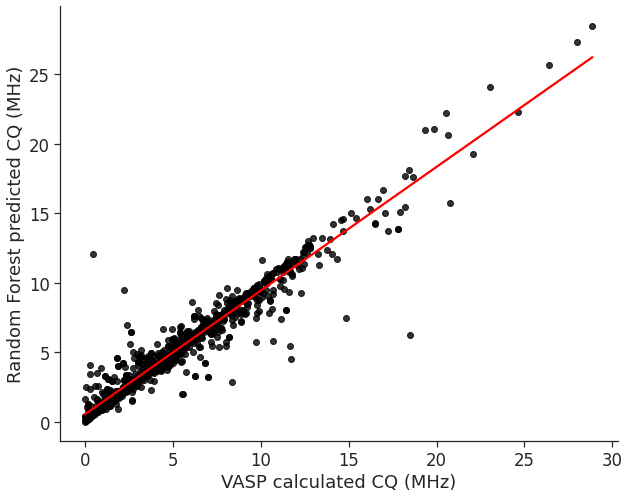

In [19]:
# plot model's performance over the test set
grid_test(X_test, y_test, grid, plot=True)

In [20]:
# Save the model
joblib.dump(grid.best_estimator_, model_path + "struc.pkl")

['../models/struc.pkl']

#### II. Improved model with structural+elemental features

In [18]:
# split y and x
y = nmr_struc_data[["CQ", "is_O"]]
x = nmr_struc_data.loc[:, "fbl_average":]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, random_state=5, stratify=y["atom_combination"]
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 4982
Size of test set: 880


In [19]:
# define the param space for randomized search
param = {
    "n_estimators": [2000],
    "max_depth": randint(low=10, high=100),
    "max_features": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples_split": list(range(2, 10)),
    "min_samples_leaf": list(range(1, 8)),
}

grid = model_train(X_train, y_train, "randomforest", param)

In [20]:
# print the model's performance
grid_performance(grid)

training score: R2 = 0.9402893835147236, RMSE = 0.9686945508779397, MAE = 0.46633261411636073
Best estimator: RandomForestRegressor(max_depth=21, max_features=0.4, min_samples_split=5,
                      n_estimators=2000, random_state=10)


test scores: R2 = 0.9584015996430141, RMSE = 0.8255824244182288, MAE = 0.41694763037532295
Index(['VASP calculated CQ (MHz)', 'Random Forest predicted CQ (MHz)'], dtype='object')


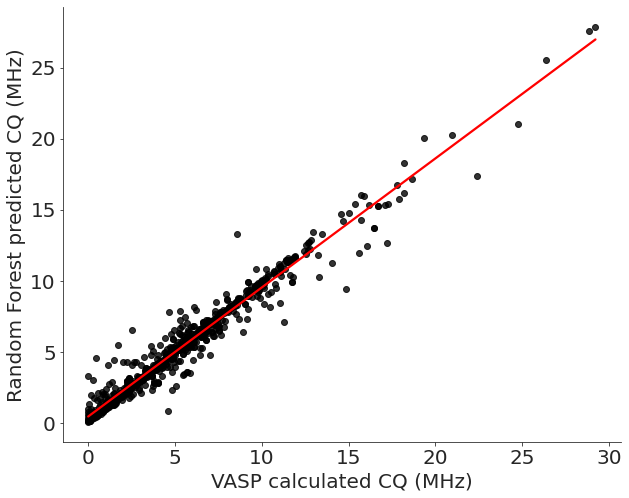

In [21]:
# plot model's performance over the test set
grid_test(X_test, y_test, grid, plot=True)

In [22]:
# Save the model
joblib.dump(grid.best_estimator_, model_path + "struc+ele.pkl")

['../models/struc+ele.pkl']

#### III. Test model with SMOTE rebalance

In [21]:
# split y and x
y = nmr_struc_data[["CQ", "atom_combination", "is_O"]]
x = nmr_struc_data.loc[:, "fbl_average":]

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=5, stratify=y["atom_combination"]
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 4681
Size of test set: 1171


In [22]:
# resample the dataset using SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

train = pd.concat([X_train, y_train["CQ"]], axis=1)
label = y_train["is_O"]

over = SMOTE(sampling_strategy=0.75)
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [("o", over), ("u", under)]
pipeline = Pipeline(steps=steps)

train, label = pipeline.fit_resample(train, label)
y_train = pd.concat([train["CQ"], label], axis=1)
X_train = train.drop(columns=["CQ"])

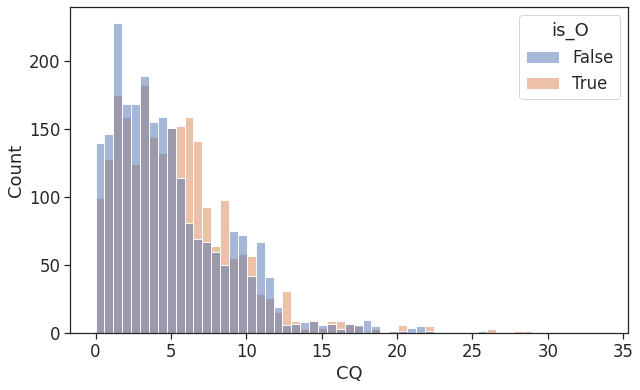

In [23]:
# now the data is balanced
plt.figure(figsize=(10, 6))
sns.histplot(data=pd.concat([X_train, y_train], axis=1), x="CQ", hue="is_O")
plt.show()

In [25]:
# define the param space for randomized search
param = {
    "n_estimators": randint(low=100, high=1500),
    "max_depth": randint(low=10, high=100),
    "max_features": [0.1, 0.2, 0.3, 0.4, 0.5],
    "min_samples_split": list(range(2, 10)),
    "min_samples_leaf": list(range(1, 8)),
}

grid = model_train(X_train, y_train, "randomforest", param, n_iter=10, cv=5)

In [28]:
# print the model's performance
grid_performance(grid)

training score: R2 = 0.9280201094889329, RMSE = 1.0722985581349322, MAE = 0.5269786673217822
Best estimator: RandomForestRegressor(max_depth=56, max_features=0.4, min_samples_split=3,
                      n_estimators=962, random_state=10)


test scores: R2 = 0.947199842325025, RMSE = 0.8651599807332604, MAE = 0.4488440140608935


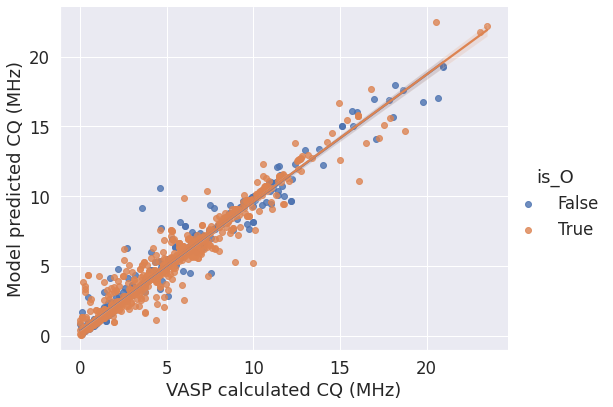

In [29]:
# plot model's performance over the test set
grid_test(X_test, y_test, grid, plot=True, is_O=True)

In [ ]:
# Save the model
joblib.dump(grid.best_estimator_, model_path + "smote.pkl")

#### IV. XGboost

In [24]:
# split y and x
y = nmr_struc_data[["CQ", "is_O"]]
x = nmr_struc_data.loc[:, "fbl_average":]

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=5, stratify=y["atom_combination"]
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 4689
Size of test set: 1173


In [25]:
# define the param space for randomized search
param = {
    "learning_rate": uniform(0, 1),
    "max_depth": randint(3, 50),
    "min_child_weight": randint(1, 10),
    "eta": uniform(0.01, 0.2),
    "gamma": uniform(0, 1),
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 100],
    "subsample": uniform(0, 1),
    "colsample_bytree": uniform(0, 1),
}

grid = model_train(X_train, y_train, "XGboost", param)

In [26]:
# print the model's performance
grid_performance(grid)

training score: R2 = 0.9518588332248298, RMSE = 0.8701529459562894, MAE = 0.39457895948148075
Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8520099632159346,
             enable_categorical=False, eta=0.19826406046360912,
             gamma=0.11610586343483797, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.10948689905515252,
             max_delta_step=0, max_depth=39, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1,
             subsample=0.6358998203240711, tree_method='hist',
             validate_parameters=1, verbosity=None)


test scores: R2 = 0.9749974195167196, RMSE = 0.6309978655590174, MAE = 0.3124050013247081
Index(['VASP calculated CQ (MHz)', 'Random Forest predicted CQ (MHz)'], dtype='object')


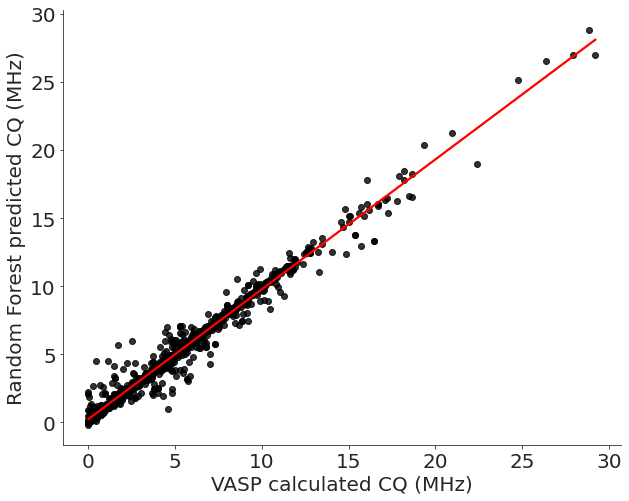

In [27]:
# plot model's performance over the test set
grid_test(X_test, y_test, grid, plot=True)

In [29]:
# Save the model
joblib.dump(grid.best_estimator_, model_path + "xgboost.pkl")

['../models/xgboost.pkl']